# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## Intelligence

We will give a try to transfer learning, using `Keras`.  
Specifically, we will reuse model `XXX` from Keras [model zoo](https://keras.io/applications/), and perform standard data augmentation using [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) (see e.g. [here](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) for use examples).

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import re
# import pandas as pd
import time
import pickle
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

# from IAFlash.helpers import DataHandler, ImageWorker # needs correct working directory

Using TensorFlow backend.


### Variables

In [2]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0')
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))
data_format = 'channels_last'
nbClass = 196

# image processing
edge = int(re.findall('edge([0-9]*)',pathToDataDir)[0])
if 'bwTrue' in pathToDataDir:
    mode = 'grayscale'
elif 'bwFalse' in pathToDataDir:
    mode = 'rgb'
else:
    raise ValueError('color mode not undestood from data directory name')
    
# model compilation params
loss = 'categorical_crossentropy'
#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#optim = Adamax()
optim = 'adam'
metric = ['accuracy']

# model training params
epochs = 3
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1)
checkpoint = ModelCheckpoint(os.path.join(pathToIntellDir, 'model_v0.hdf5'),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             period=1)
reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.1,
                             patience=4,
                             verbose=1)

# seed
seed = 8
np.random.seed(seed)

### Intelligence

**Data augmentation**

The [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) object allows to augment data easily. Depending on the method used, data augmentation can be done once-for-all or on-the-fly. We will choose on-the-fly augmentation to avoid storing to large data.

In [3]:
# prepare a dataset augmenter
batch_size = 32

# NB: only train data need augmentation
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   zca_whitening=False, # explore this later
                                   zca_epsilon=1e-06,
                                   rotation_range=20, # 0
                                   width_shift_range=0.0,
                                   height_shift_range=0.0,
                                   shear_range=0.0,
                                   zoom_range=0.0,
                                   channel_shift_range=0.0,
                                   fill_mode='constant', #'nearest',
                                   cval=0.0,
                                   horizontal_flip=True, # False
                                   vertical_flip=False,
                                   rescale=1./255, # None
                                   preprocessing_function=None,
                                   data_format=data_format)

train_generator = train_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Train'), # "it should contain one subdirectory per class"
                                                    target_size=(edge, edge),
                                                    color_mode=mode,
                                                    classes=None, # will infer from the directory structure
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=seed,
                                                    follow_links=False,
                                                    interpolation='nearest',
#                                                     save_to_dir=pathToDataDir, # use this to print one batch when calling train_generator[batchIdx]
#                                                     save_prefix='train_',      #
#                                                     save_format='png'          #
                                                   )

# NB: validation data use `ImageDataGenerator` for the conveniance of directory parsing
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Validation'),
                                                              target_size=(edge, edge),
                                                              color_mode=mode,
                                                              class_mode='categorical',
                                                              batch_size=1, # most basic behaviour
                                                              seed=seed,
#                                                               save_to_dir=pathToDataDir, # use this to print one batch when calling validation_generator[batchIdx]
#                                                               save_prefix='valid_',      #
#                                                               save_format='png'          #
                                                             )

# NB: same thing for test data
test_datagen = validation_datagen

test_generator = test_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Test'),
                                                  target_size=(edge, edge),
                                                  color_mode=mode,
                                                  class_mode='categorical',
                                                  batch_size=1, # most basic behaviour
                                                  seed=seed)

Found 8144 images belonging to 196 classes.
Found 1600 images belonging to 196 classes.
Found 6441 images belonging to 196 classes.


train data:


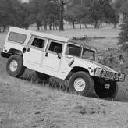

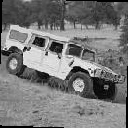

validation data (should not change):


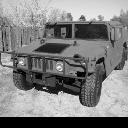

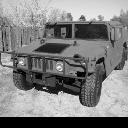

In [4]:
# example of data augmentation
i = 3

print('train data:')
im = Image.open(os.path.join(pathToDataDir, 'Train', train_generator.filenames[i]))
x_im = np.array(im).reshape((edge, edge, 1))
x_im_t = train_datagen.random_transform(x_im, seed=np.random.choice(100,1)[0]).reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

print('validation data (should not change):')
im = Image.open(os.path.join(pathToDataDir, 'Validation', validation_generator.filenames[i]))
x_im = np.array(im).reshape((edge, edge, 1))
x_im_t = validation_datagen.random_transform(x_im, seed=np.random.choice(100,1)[0]).reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

**Model**

In [19]:
# build a basic model

model = Sequential()
model.add(Conv2D(input_shape=train_generator.image_shape,
                 filters=1,
                 kernel_size=9,
                 strides=1,
                 padding='same',
                 data_format=train_generator.data_format,
                 dilation_rate=1,
                 activation=None, # explicit it later
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3),
                       strides=None,
                       padding='same',
                       data_format=train_generator.data_format))
model.add(Flatten())
model.add(Dense(train_generator.num_classes))
model.add(Activation('softmax'))

model.summary()

# compile

model.compile(loss=loss,
              optimizer=optim,
              metrics=metric)

# train

model_history = model.fit_generator(train_generator,
                                    epochs=epochs,
                                    steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
                                    validation_data=validation_generator,
                                    validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
                                    callbacks=[earlystop,checkpoint,reducelr])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 1)       82        
_________________________________________________________________
activation_5 (Activation)    (None, 128, 128, 1)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1849)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               362600    
_________________________________________________________________
activation_6 (Activation)    (None, 196)               0         
Total params: 362,682
Trainable params: 362,682
Non-trainable params: 0
_________________________________________________________________
Epoc

KeyboardInterrupt: 

**Performance assessment**

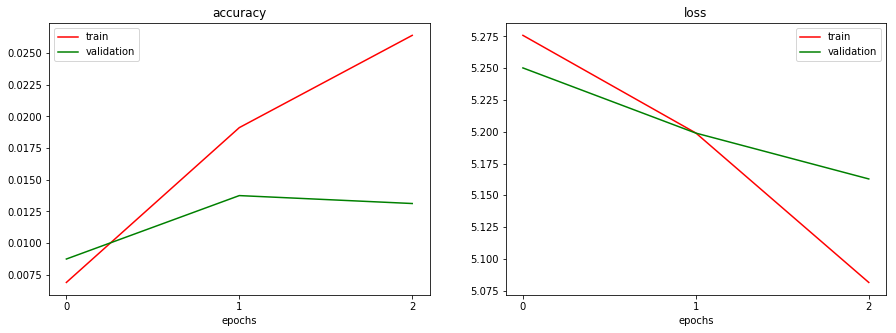

In [9]:
# plot the learning performance

f = plt.figure(figsize=(15,5))

ax = f.add_subplot(1,2,1)
ax.plot(model_history.history['acc'], 'r')
ax.plot(model_history.history['val_acc'], 'g')
ax.set_xticks(np.arange(0, epochs, 1))
ax.set_xlabel('epochs')
# ax.set_ylabel('accuracy')
ax.set_title('accuracy')
ax.legend(['train','validation'])
 
ax = f.add_subplot(1,2,2)
ax.plot(model_history.history['loss'], 'r')
ax.plot(model_history.history['val_loss'], 'g')
ax.set_xticks(np.arange(0, epochs, 1))
ax.set_xlabel('epochs')
# ax.set_ylabel('loss')
ax.set_title('loss')
ax.legend(['train','validation'])

plt.show()

In [10]:
# assess performance

assess_generator = validation_generator
# assess_generator = test_generator # only in the end :)

assess_model = model

In [17]:
# predictions

score = assess_model.predict_generator(assess_generator,
                                       steps=len(assess_generator),
                                       max_queue_size=10,
                                       workers=1,
                                       use_multiprocessing=False,
                                       verbose=0)
predicted = np.argmax(score, axis=1)


top 5 predictions for image 201 with true class 27:
   146 (0.022136565297842026)
   16 (0.016104286536574364)
   120 (0.014266987331211567)
   138 (0.013793242163956165)
   170 (0.013230768963694572)
correct class at rank: 118 out of 196

mean accuracy: 0.00625

confusion matrix


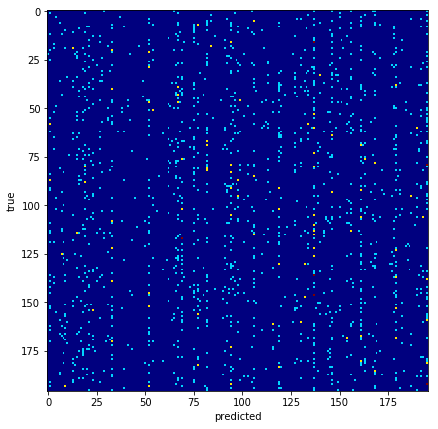


classification report


/Users/arthur/anaconda3/envs/tree/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# ranked predictions
i,K = 201,5

true_i = assess_generator.classes[i]
score_i = score[i,:]
argsort_i = np.argsort(score_i)[::-1]
print('\ntop {} predictions for image {} with true class {}:'.format(K, i, true_i))
for k in range(K):
    print('   {} ({})'.format(argsort_i[k],score_i[argsort_i[k]]))
print('correct class at rank: {} out of {}'.format(np.where(argsort_i==true_i)[0][0], assess_generator.num_classes))

# accuracy
acc = np.mean(assess_generator.classes == predicted)
print('\nmean accuracy: {}'.format(acc))

# confusion matrix
print('\nconfusion matrix')
conf = confusion_matrix(assess_generator.classes, predicted)
f = plt.figure(figsize=(7, 7))
ax = f.add_subplot(1,1,1)
ax.imshow(conf, cmap=plt.cm.jet, interpolation='nearest')
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

print('\nclassification report')
report = classification_report(assess_generator.classes,
                               predicted,
                               target_names=np.sort(list(assess_generator.class_indices.keys())).tolist())
# print(report)
# print(classification_report_todf(report))

In [13]:
# import pandas as pd

# def classification_report_todf(report):
#     '''
#     inspired from https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format#41044355
#     '''
#     report_data = []
#     lines = report.split('\n')
#     for line in lines[2:-3]:
#         row = {}
#         row_data = line.split('      ')
#         row_data = list(filter(None, row_data))
#         row['class'] = row_data[0]
#         row['precision'] = float(row_data[1])
#         row['recall'] = float(row_data[2])
#         row['f1_score'] = float(row_data[3])
#         row['support'] = float(row_data[4])
#         report_data.append(row)
#     dataframe = pd.DataFrame.from_dict(report_data)
#     return dataframe

### Save material for client use

In [15]:
# data preprocessors
pickle.dump(test_datagen, open(os.path.join(pathToIntellDir, 'datagen.pkl'),'wb'))
pickle.dump(assess_generator.class_indices, open(os.path.join(pathToIntellDir, 'classesDict.pkl'),'wb'))

# model
assess_model.save(os.path.join(pathToIntellDir, 'model.h5'))